In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
le = LabelEncoder()
import seaborn as sns
color_pal = sns.color_palette()

# Plotting the RMSE during training
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [93]:
# # grid search cv param
# param_grid = {
#     'n_estimators': [300, 500, 700],
#     'max_depth': [5, 7, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'lambda': [1, 5, 10],
#     'alpha': [0, 0.1, 0.5]
# }

# Best Parameters: {
# 'colsample_bytree': 1.0, 
# 'learning_rate': 0.05, 
# 'max_depth': 7, 
# 'n_estimators': 300, 
# 'subsample': 0.8
# }


param_grid = {
    'learning_rate': [0.05, 0.1, 0.3],
    'max_depth': [7, 8, 9],
    'n_estimators': [300, 400],
    'subsample': [0.5, 0.8], 
    'colsample_bytree': [1.0],
    'lambda': [5, 7],
    'alpha': [0.5, 0.8]
}

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.8, 1.0], 
#     'colsample_bytree': [0.8, 1.0],
# }

# xgb param
xgb_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 1.0,
    'random_state': 42,
    'objective' :'reg:squarederror'
}

In [94]:
# Read the data into a pandas DataFrame
df = pd.read_csv('CodeChallenge_Dataset_2021-2023_Set 1.csv')

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'].str.split().str[0])

# Group by 'Date' and 'ProductId', and sum the 'Amount' column
df = df.groupby(['Date', 'ProductId'])['Amount'].sum().reset_index()
df['ProductId'] = le.fit_transform(df['ProductId'])
df = df.set_index('Date')
df[:10]

,ProductId,Amount
Date,,
2021-01-02,200,414227.28
2021-01-04,200,881044.68
2021-01-05,200,513325.43
2021-01-06,200,281528.52
2021-01-07,200,134804.83
2021-01-08,200,480838.74
2021-01-09,200,5131.75
2021-01-11,200,424555.95
2021-01-12,200,266479.07


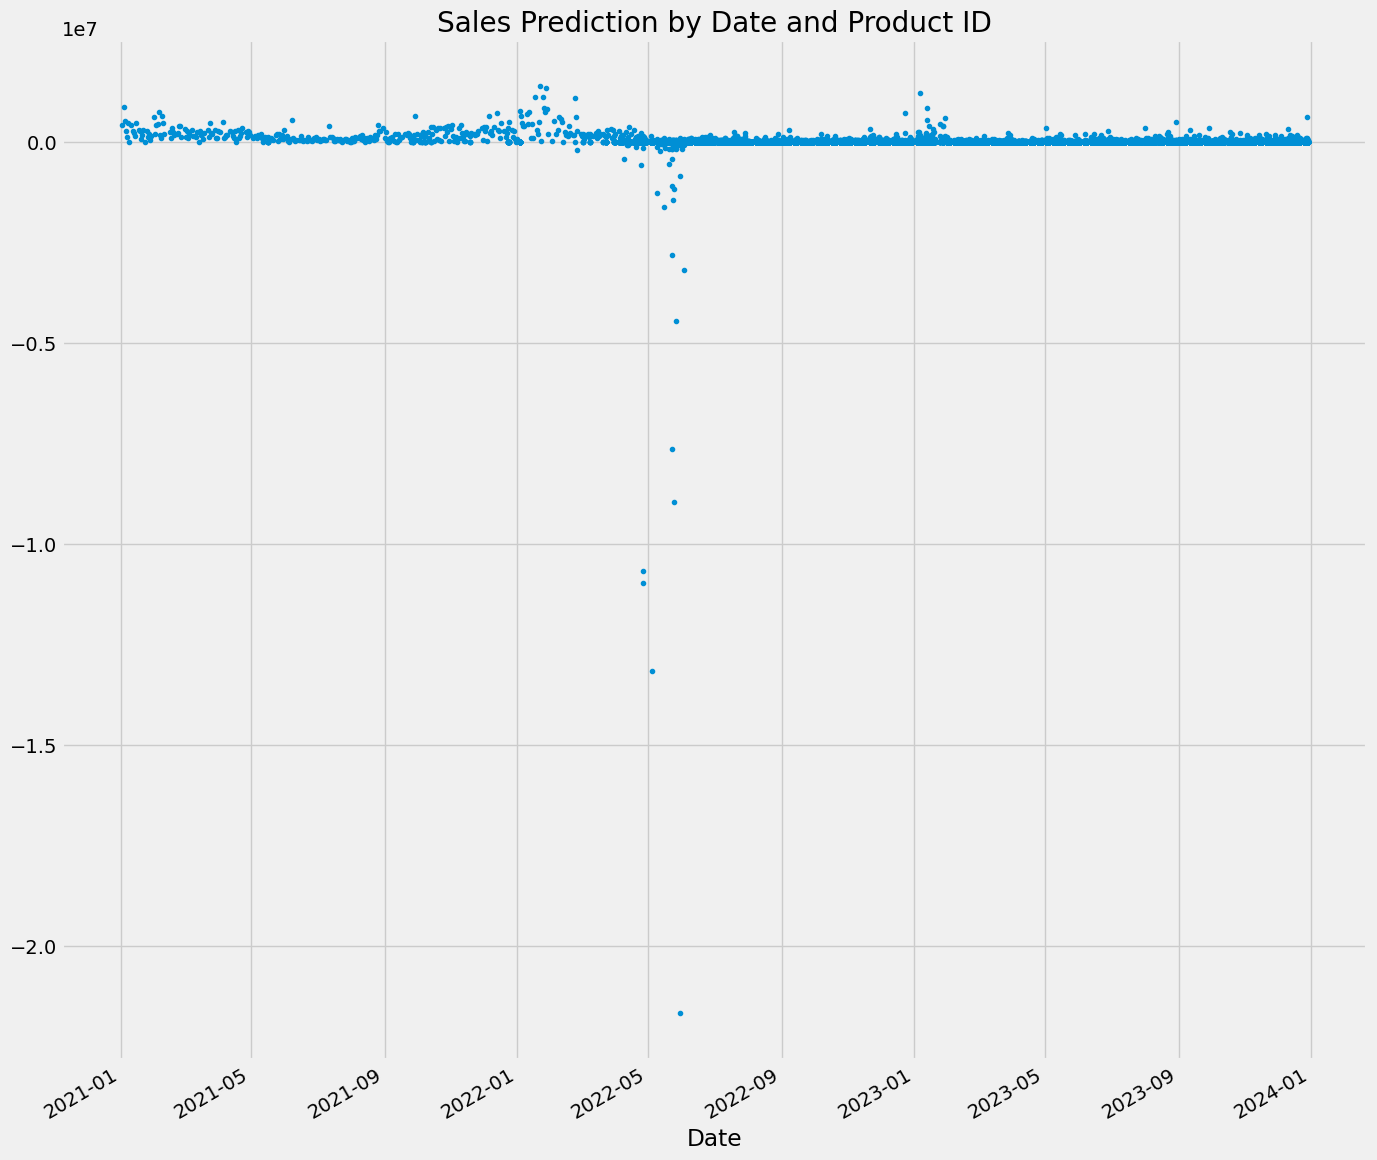

In [95]:
df['Amount'].plot(style='.',
        figsize=(15, 15),
        color=color_pal[0],
        title='Sales Prediction by Date and Product ID')
plt.show()

In [96]:
# remove the negative value which is the outlier
df = df[df['Amount'] >= 0]

In [97]:
# Outlier detection using IQR
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Filter out outliers
df = df[~((df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR)))]


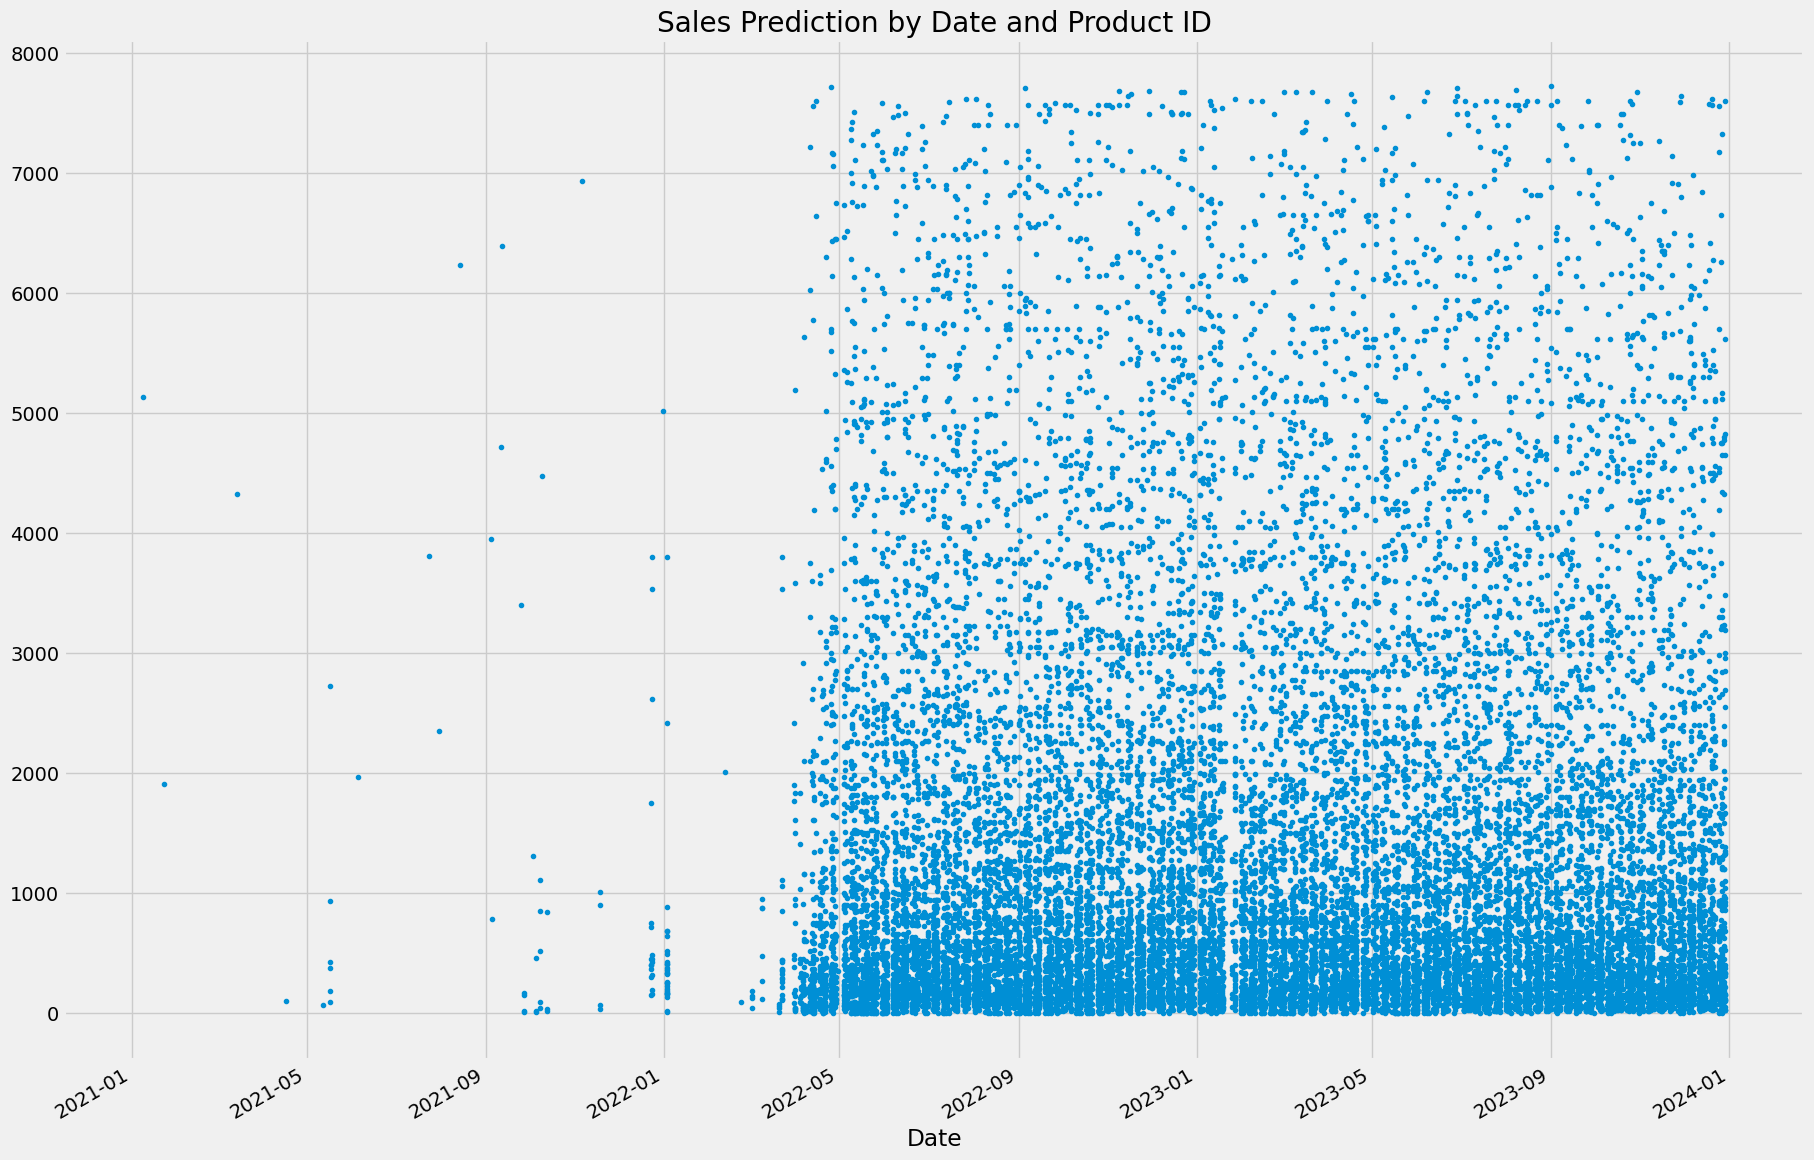

In [98]:
df['Amount'].plot(style='.',
        figsize=(20, 15),
        color=color_pal[0],
        title='Sales Prediction by Date and Product ID')
plt.show()

In [99]:
len(df)

20829

In [100]:
df['day'] = df.index.day
df['month'] = df.index.month
df['weekday'] = df.index.weekday
df['dayofweek'] = df.index.dayofweek
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
df['weekday_month_interaction'] = df['weekday'] * df['month']

In [101]:
df['Amount_lag_1'] = df['Amount'].shift(1)  # Sales from the previous day
df['Amount_lag_7'] = df['Amount'].shift(7)  # Sales from 7 days ago
df['Amount_rolling_mean_3'] = df['Amount'].rolling(window=3).mean()  # 3-day rolling mean
df['Amount_rolling_mean_7'] = df['Amount'].rolling(window=7).mean()  # 7-day rolling mean
df['ema_3'] = df['Amount'].ewm(span=3).mean()
df['ema_7'] = df['Amount'].ewm(span=7).mean()

# Cumulative sales trend
df['cumulative_sales'] = df['Amount'].cumsum()

In [102]:
df.fillna(0, inplace=True)

In [103]:
df.columns

Index(['ProductId', 'Amount', 'day', 'month', 'weekday', 'dayofweek',
       'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
       'is_month_end', 'is_weekend', 'weekday_month_interaction',
       'Amount_lag_1', 'Amount_lag_7', 'Amount_rolling_mean_3',
       'Amount_rolling_mean_7', 'ema_3', 'ema_7', 'cumulative_sales'],
      dtype='object')

In [104]:
# Step 2: Define feature columns and target
X = df[['ProductId', 'day', 'month', 'weekday', 'dayofweek',
       'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
       'Amount_lag_1', 'Amount_lag_7', 'Amount_rolling_mean_3',
       'Amount_rolling_mean_7', 'is_weekend', 'cumulative_sales', 'ema_3', 'ema_7']]  # Features based on the date
y = df['Amount']  # Target variable (sales amount)

In [105]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [106]:
# Step 4: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [107]:
len(X_train)

16663

In [108]:
len(X_test)

4166

In [109]:
xgb_model = xgb.XGBRegressor(
    **xgb_params
)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=300,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'alpha': [0.5, 0.8], 'colsample_bytree': [1.0],
                         'lambda': [5, 7], 'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [7, 8, 9], 'n_estimators': [300, 400],
                         'subsample': [0.5, 0.8]},
             scoring='neg_mean_squared_error', verbose=1)

In [110]:
# Step 6: Use the best model from the grid search to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Step 7: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Best Parameters: {grid_search.best_params_}")
print(f"RMSE: {rmse}")

# rmse 1 - 790.6659721083591
# rmse 2 - 137.43643486903306
# rmse 3 - 138.63130912770134
# rmse 4 - 137.43643486903306

Best Parameters: {'alpha': 0.5, 'colsample_bytree': 1.0, 'lambda': 5, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 400, 'subsample': 0.5}
RMSE: 153.23070069473735


In [111]:
# Set up eval_set for training and validation metrics
eval_set = [(X_train, y_train), (X_test, y_test)]
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Retrieve evaluation results
results = best_model.evals_result()

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

[0]	validation_0-rmse:1578.95572	validation_1-rmse:1526.09669
[1]	validation_0-rmse:1506.67142	validation_1-rmse:1457.67589
[2]	validation_0-rmse:1438.04857	validation_1-rmse:1391.32791
[3]	validation_0-rmse:1372.79213	validation_1-rmse:1343.75375


[4]	validation_0-rmse:1311.07939	validation_1-rmse:1284.36001
[5]	validation_0-rmse:1252.20742	validation_1-rmse:1228.32046
[6]	validation_0-rmse:1196.15162	validation_1-rmse:1187.36625
[7]	validation_0-rmse:1143.12939	validation_1-rmse:1138.27704
[8]	validation_0-rmse:1092.16618	validation_1-rmse:1089.68514
[9]	validation_0-rmse:1043.68363	validation_1-rmse:1042.85359
[10]	validation_0-rmse:998.19866	validation_1-rmse:998.95516
[11]	validation_0-rmse:954.78381	validation_1-rmse:956.97396
[12]	validation_0-rmse:913.01027	validation_1-rmse:917.29442
[13]	validation_0-rmse:873.74766	validation_1-rmse:879.64737
[14]	validation_0-rmse:835.93151	validation_1-rmse:843.37382
[15]	validation_0-rmse:799.96761	validation_1-rmse:808.75197
[16]	validation_0-rmse:765.74801	validation_1-rmse:776.47209
[17]	validation_0-rmse:733.31827	validation_1-rmse:744.98091
[18]	validation_0-rmse:702.79077	validation_1-rmse:715.33555
[19]	validation_0-rmse:673.24320	validation_1-rmse:686.85480
[20]	validation_0-

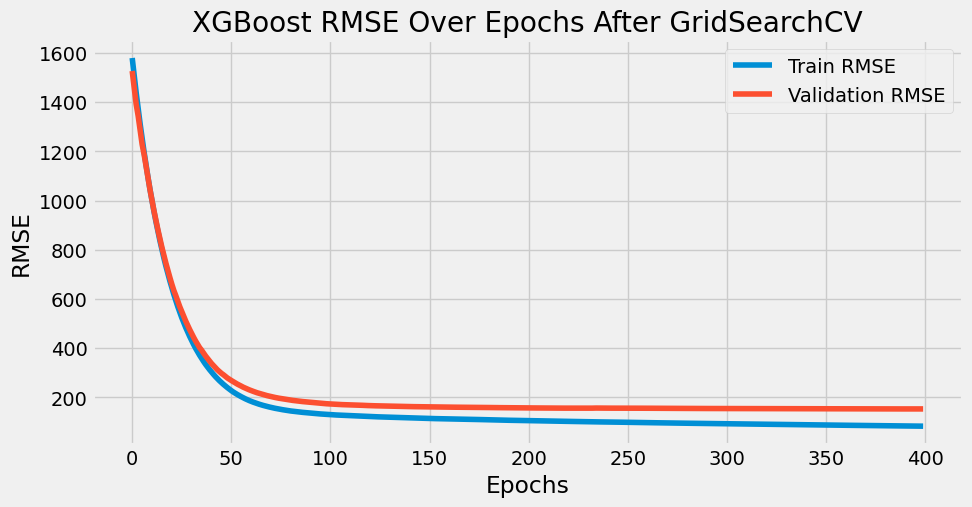

In [112]:
# Plot RMSE
plt.figure(figsize=(10,5))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Epochs After GridSearchCV')
plt.legend()
plt.show()